## 0. Configurações Iniciais

### 0.1 Importação de Bibliotecas e Configurações

In [31]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, loguniform
from random import seed, randrange
from math import sqrt
import time

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# Configurações para visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### 0.2 Definição de LVQ

## 1. Carregamento dos Dados

Nesta seção, realizamos o carregamento dos dados.

In [2]:
# Carregamento dos dados de treinamento
train_df = pd.read_csv('data/train.csv')

# Separar features e target
X = train_df.drop(columns=['ACTION'])
y = train_df['ACTION']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

## 4. Pré-processamento

In [3]:
# Lista de colunas que são categorias, mas estão com tipo numérico
categorical_int_cols = [
    'MGR_ID',
    'ROLE_ROLLUP_2',
    'ROLE_DEPTNAME',
    'ROLE_TITLE',
    'ROLE_FAMILY_DESC',
    'ROLE_CODE',
    'RESOURCE'
]
for col in categorical_int_cols:
    X_train[col] = X_train[col].astype(str) # Ou .astype('object')
    X_test[col] = X_test[col].astype(str) # o mesmo no teste!
    
print("Novos tipos de dados em X_train:")
print(X_train[categorical_int_cols].info())

Novos tipos de dados em X_train:
<class 'pandas.core.frame.DataFrame'>
Index: 26215 entries, 10137 to 31226
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MGR_ID            26215 non-null  object
 1   ROLE_ROLLUP_2     26215 non-null  object
 2   ROLE_DEPTNAME     26215 non-null  object
 3   ROLE_TITLE        26215 non-null  object
 4   ROLE_FAMILY_DESC  26215 non-null  object
 5   ROLE_CODE         26215 non-null  object
 6   RESOURCE          26215 non-null  object
dtypes: object(7)
memory usage: 1.6+ MB
None


### Divisão das colunas em alta e baixa cardinalidade e remoção de colunas.

In [4]:
# Remover as colunas indesejadas
cols_to_remove = ['ROLE_ROLLUP_1', 'ROLE_FAMILY']
X_train_clean = X_train.drop(columns=cols_to_remove, errors='ignore')
X_test_clean = X_test.drop(columns=cols_to_remove, errors='ignore')

In [5]:
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]


print("Colunas de baixa e alta cardinalidade em X_train_clean:")
print("Baixa cardinalidade:", low_card_features)
print("Alta cardinalidade:", high_card_features)

print("\nColunas de baixa e alta cardinalidade em X_train:")
print("Baixa cardinalidade:", low_card_features_2)
print("Alta cardinalidade:", high_card_features_2)


Colunas de baixa e alta cardinalidade em X_train_clean:
Baixa cardinalidade: ['ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']

Colunas de baixa e alta cardinalidade em X_train:
Baixa cardinalidade: ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY', 'ROLE_CODE']
Alta cardinalidade: ['RESOURCE', 'MGR_ID', 'ROLE_FAMILY_DESC']


### Comparação de Estratégias de Pré-processamento

Neste experimento, avaliamos o impacto da remoção de colunas no pré-processamento dos dados. Foram testados dois cenários:

- **Com remoção de colunas:**  
    As colunas `ROLE_ROLLUP_1` e `ROLE_FAMILY` foram removidas antes do pré-processamento.

- **Sem remoção de colunas:**  
    Todas as colunas originais foram mantidas no pré-processamento.

O pré-processador utilizado para ambos os cenários foi:

- **Pré-processador para os modelos:**  
    `OneHotEncoder` para variáveis de baixa cardinalidade (`low_cardinality_features`) e `TargetEncoder` para variáveis de alta cardinalidade (`high_cardinality_features`).

A comparação dos resultados permite avaliar se a exclusão dessas colunas influencia o desempenho dos modelos de classificação.

In [6]:
# Definições de baixa e alta cardinalidade para ambos os conjuntos
low_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() < 450]
high_card_features = [col for col in X_train_clean.columns if X_train_clean[col].nunique() >= 450]

low_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() < 450]
high_card_features_2 = [col for col in X_train.columns if X_train[col].nunique() >= 450]

# Pré-processador para X_train_clean
preprocessor_clean = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features)
], remainder='passthrough')

# Pré-processador para X_train (todas as colunas)
preprocessor_full = ColumnTransformer(transformers=[
    ('low_card', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary', min_frequency=0.01), low_card_features_2),
    ('high_card', TargetEncoder(smoothing=1.0, min_samples_leaf=20), high_card_features_2)
], remainder='passthrough')




In [7]:
def create_pipeline(classifier, use_full=False):
    """
    Cria um pipeline de machine learning com duas etapas principais:
    1. Um pré-processador para transformar os dados.
    2. Um classificador para realizar a predição.
    
    Parâmetros:
    - classifier: o estimador/classificador a ser usado.
    - use_full: se True, usa preprocessor_full; senão, usa preprocessor_clean.
    """
    preproc = preprocessor_full if use_full else preprocessor_clean
    return Pipeline(steps=[
        ('preprocessor', preproc),
        ('classifier', classifier)
    ])
    

In [36]:
from imblearn.under_sampling import NeighbourhoodCleaningRule



In [37]:
# Aplicar o NeighbourhoodCleaningRule nos dados "clean" (X_train_clean, y_train)
ncr_clean = NeighbourhoodCleaningRule(
    sampling_strategy='majority',
    n_neighbors=5,
    kind_sel='mode',
    n_jobs=-1
)
X_ncr_clean, y_ncr_clean = ncr_clean.fit_resample(X_train_clean, y_train)

print("Shape após NCR (clean):", X_ncr_clean.shape, y_ncr_clean.shape)
print("Distribuição das classes após NCR (clean):")
print(y_ncr_clean.value_counts())

Shape após NCR (clean): (21465, 7) (21465,)
Distribuição das classes após NCR (clean):
ACTION
1    19947
0     1518
Name: count, dtype: int64


## 5. Seleção de Modelos Fase 

### 5.1 Fase 1

Modelos avaliados nesta fase:

- **K-NN** (K-Nearest Neighbors)
- **Árvore de Decisão** (Decision Tree)
- **Random Forest**
- **SVM** (Support Vector Machine)
- **LVQ** (Learning Vector Quantization)


In [ ]:
models = {
    "K-NN": KNeighborsClassifier(),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM (Kernel RBF)": SVC(random_state=42, max_iter=1000, probability=True)
}


In [32]:
# Dicionário de métricas que queremos calcular
scoring = {
    'precision_0': make_scorer(precision_score, pos_label=0, zero_division=0),
    'precision_1': make_scorer(precision_score, pos_label=1, zero_division=0),
    'recall_0': make_scorer(recall_score, pos_label=0, zero_division=0),
    'recall_1': make_scorer(recall_score, pos_label=1, zero_division=0),
    'f1_0': make_scorer(f1_score, pos_label=0, zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Estratégia de validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados finais
results_clean = {}
results_full = {}
results_NCR = {}

In [13]:
# Avaliação com colunas removidas (X_train_clean)
for name, model in models.items():
    print(f"Avaliando X_train_clean: {name}...")
    pipeline = create_pipeline(model, use_full=False)
    scores = cross_validate(
        pipeline, X_train_clean, y_train,
        cv=cv_strategy, scoring=scoring, n_jobs=-1
    )
    results_clean[name] = {
        'roc_auc_media': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean()
    }


Avaliando X_train_clean: K-NN...


KeyboardInterrupt: 

In [59]:
# Avaliação com todas as colunas (X_train_full)
for name, model in models.items():
    print(f"Avaliando (todas as colunas): {name}...")
    pipeline = create_pipeline(model, use_full=True)
    scores = cross_validate(
        pipeline, X_train, y_train,
        cv=cv_strategy, scoring=scoring, n_jobs=-1
    )
    results_full[name] = {
        'roc_auc_media': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean()
    }


Avaliando (todas as colunas): K-NN...
Avaliando (todas as colunas): Árvore de Decisão...
Avaliando (todas as colunas): Random Forest...
Avaliando (todas as colunas): SVM (Kernel RBF)...


In [72]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

# Avaliando com todas as colunas e  NeighbourhoodCleaningRule  para lidar com desbalanceamento

# Aplicar o NeighbourhoodCleaningRule para balancear as classes (classe minoritária = 0)
ncr = NeighbourhoodCleaningRule(
    sampling_strategy='majority',
    n_neighbors=5,
    kind_sel='mode',
    n_jobs=-1
)
X_ncr, y_ncr = ncr.fit_resample(X_train_full, y_train)

# Avaliação dos modelos após NCR
for name, model in models.items():
    print(f"Avaliando NCR todas as colunas: {name}...")
    pipeline = Pipeline([
        ('classifier', model)
    ])
    scores = cross_validate(
        pipeline, X_ncr, y_ncr,
        cv=cv_strategy, scoring=scoring, n_jobs=-1
    )
    results_NCR[name] = {
        'roc_auc_media': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean()
    }


Avaliando NCR todas as colunas: K-NN...
Avaliando NCR todas as colunas: Árvore de Decisão...
Avaliando NCR todas as colunas: Random Forest...
Avaliando NCR todas as colunas: SVM (Kernel RBF)...


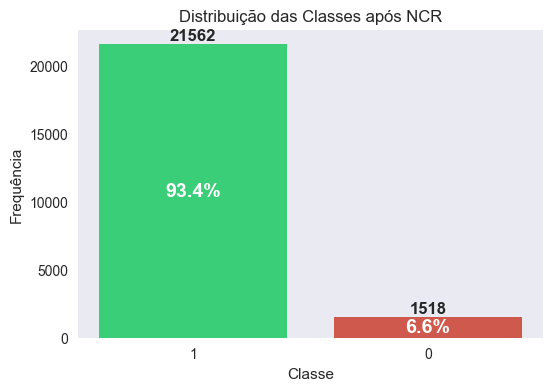

In [82]:
# Visualizar a contagem e proporção das classes após o balanceamento
counts = y_ncr.value_counts()
proportions = y_ncr.value_counts(normalize=True)

# Visualização gráfica
plt.figure(figsize=(6,4))
bars = plt.bar(counts.index.astype(str), counts.values, color=["#3ACE78", "#CE594C"])
plt.title("Distribuição das Classes após NCR")
plt.xlabel("Classe")
plt.ylabel("Frequência")
for bar, count, prop in zip(bars, counts.values, proportions.values):
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height()/2,
        f'{prop:.1%}', 
        ha='center', va='center', fontweight='bold', color='white', fontsize=14
    )
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        bar.get_height() + 50,
        f'{count}', 
        ha='center', va='bottom', fontweight='bold'
    )
plt.grid(False)
plt.show()


In [62]:
results_df = pd.DataFrame(results_clean).T
results_df = results_df.sort_values(by='roc_auc_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO CLEAN")
print("=" * 60)
print(results_df)


             RESULTADO FINAL DA AVALIAÇÃO CLEAN
                   roc_auc_media  roc_auc_std  precision_0_media  \
Random Forest           0.821213     0.011109           0.564985   
K-NN                    0.758339     0.019685           0.525659   
Árvore de Decisão       0.705745     0.019884           0.417757   
SVM (Kernel RBF)        0.617432     0.038916           0.213188   

                   precision_1_media  recall_0_media  recall_1_media  
Random Forest               0.961363        0.356975        0.983115  
K-NN                        0.956874        0.278002        0.984573  
Árvore de Decisão           0.962112        0.380024        0.967364  
SVM (Kernel RBF)            0.944044        0.059272        0.973515  


In [63]:
results_df = pd.DataFrame(results_full).T
results_df = results_df.sort_values(by='roc_auc_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO FULL")
print("=" * 60)
print(results_df)


             RESULTADO FINAL DA AVALIAÇÃO FULL
                   roc_auc_media  roc_auc_std  precision_0_media  \
Random Forest           0.827701     0.014610           0.570489   
K-NN                    0.767647     0.015754           0.534789   
Árvore de Decisão       0.703897     0.018136           0.421429   
SVM (Kernel RBF)        0.595171     0.033151           0.157140   

                   precision_1_media  recall_0_media  recall_1_media  
Random Forest               0.961855        0.365567        0.983034  
K-NN                        0.957295        0.285234        0.984695  
Árvore de Decisão           0.961949        0.376734        0.968134  
SVM (Kernel RBF)            0.943636        0.043552        0.983763  


In [74]:
results_df = pd.DataFrame(results_NCR).T
results_df = results_df.sort_values(by='roc_auc_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO NCR")
print("=" * 60)
print(results_df)


             RESULTADO FINAL DA AVALIAÇÃO NCR
                   roc_auc_media  roc_auc_std  precision_0_media  \
Random Forest           0.954162     0.013267           0.784349   
K-NN                    0.863362     0.024744           0.746002   
Árvore de Decisão       0.815057     0.027209           0.648229   
SVM (Kernel RBF)        0.668310     0.033189           0.511509   

                   precision_1_media  recall_0_media  recall_1_media  
Random Forest               0.973240        0.613942        0.988127  
K-NN                        0.964484        0.482890        0.988267  
Árvore de Decisão           0.973644        0.624512        0.976116  
SVM (Kernel RBF)            0.938170        0.069140        0.994296  


In [153]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='roc_auc_media', ascending=False)

print("\n" + "=" * 60)
print("             RESULTADO FINAL DA AVALIAÇÃO BASE")
print("=" * 60)
print(results_df)


             RESULTADO FINAL DA AVALIAÇÃO BASE
                   roc_auc_media  roc_auc_std  precision_0_media  \
LVQ                     0.942056     0.001819           0.100000   
Random Forest           0.821213     0.011109           0.564985   
K-NN                    0.758339     0.019685           0.525659   
Árvore de Decisão       0.705745     0.019884           0.417757   
SVM (Kernel RBF)        0.617432     0.038916           0.213188   

                   precision_1_media  recall_0_media  recall_1_media  
LVQ                         0.942128             NaN             NaN  
Random Forest               0.961363        0.356975        0.983115  
K-NN                        0.956874        0.278002        0.984573  
Árvore de Decisão           0.962112        0.380024        0.967364  
SVM (Kernel RBF)            0.944044        0.059272        0.973515  


### 5.2 Fase 2

- **Rede Neural MLP (Multilayer Perceptron)**
- **Comitê de Redes Neurais Artificiais**
- **Comitê Heterogêneo (Stacking)**
- **XGBoost**
- **LightGBM**


In [42]:
models_fase2 = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results_fase2 = {}

In [ ]:
# Comitê de Redes Neurais: Voting com 3 MLPs com seeds diferentes
mlp1 = MLPClassifier(random_state=1, max_iter=300)
mlp2 = MLPClassifier(random_state=2, max_iter=300)
mlp3 = MLPClassifier(random_state=3, max_iter=300)
mlp_committee = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft'
)

# Comitê Heterogêneo (Stacking)
stacking = StackingClassifier(
    estimators=[
        ('mlp', MLPClassifier(random_state=42, max_iter=300)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(max_iter=200, random_state=42),
    passthrough=True,
    n_jobs=-1
)


ModuleNotFoundError: No module named 'xgboost'

In [43]:
# Avaliação dos modelos XGBoost e LightGBM com dados balanceados pelo NCR

for name, model in models_fase2.items():
    print(f"Avaliando modelo: {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor_clean),
        ('classifier', model)
    ])
    scores = cross_validate(
        pipeline, X_ncr_clean, y_ncr_clean,
        cv=cv_strategy, scoring=scoring, n_jobs=-1
    )
    results_fase2[name] = {
        'precision_0_media': scores['test_precision_0'].mean(),
        'precision_1_media': scores['test_precision_1'].mean(),
        'recall_0_media': scores['test_recall_0'].mean(),
        'recall_1_media': scores['test_recall_1'].mean(),
        'f1_0_media': scores['test_f1_0'].mean(),
        'f1_weighted_media': scores['test_f1_weighted'].mean()
    }

Avaliando modelo: XGBoost...
Avaliando modelo: LightGBM...


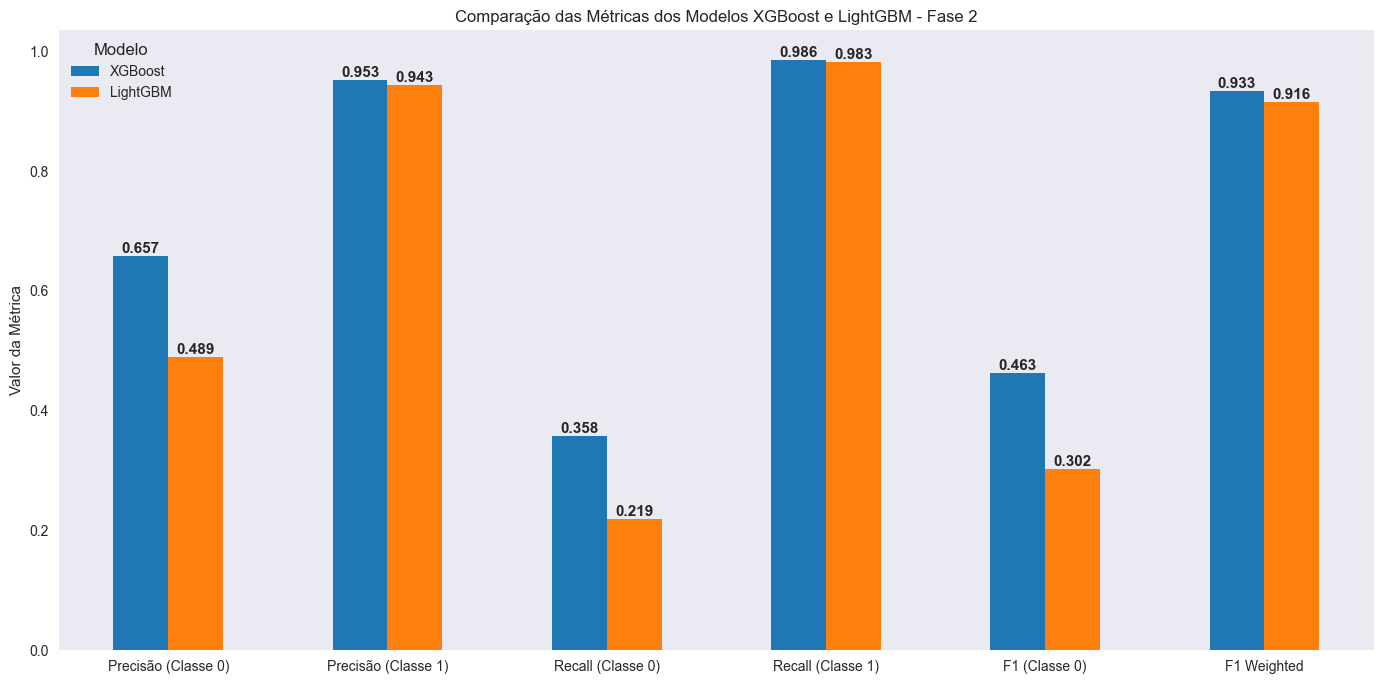

In [48]:
# Cria DataFrame das métricas dos modelos da fase 2
metrics_fase2 = pd.DataFrame(results_fase2).T

# Renomeia as colunas para melhor visualização
metrics_fase2 = metrics_fase2.rename(columns={
    'precision_0_media': 'Precisão (Classe 0)',
    'precision_1_media': 'Precisão (Classe 1)',
    'recall_0_media': 'Recall (Classe 0)',
    'recall_1_media': 'Recall (Classe 1)',
    'f1_0_media': 'F1 (Classe 0)',
    'f1_weighted_media': 'F1 Weighted'
})

# Define cores específicas para cada modelo
cores = {
    'XGBoost': '#1f77b4',   # azul para XGBoost
    'LightGBM': '#ff7f0e'   # laranja para LightGBM
}

# Transpõe o DataFrame para plotar barras lado a lado por métrica
ax = metrics_fase2.T.plot(
    kind='bar',
    figsize=(14, 7),
    color=[cores.get(model, '#333333') for model in metrics_fase2.index]
)

# Adiciona os valores no topo das barras
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.3f}', 
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Comparação das Métricas dos Modelos XGBoost e LightGBM - Fase 2')
plt.ylabel('Valor da Métrica')
plt.xticks(rotation=0)
plt.legend(title='Modelo', loc='upper left')
plt.grid(axis='y')
plt.tight_layout()
plt.grid(False)
plt.show()


## 6. Busca de Hiperparâmetros

In [88]:
# --- Dicionário com as Distribuições de Hiperparâmetros ---
param_distributions = {
    "K-NN": {
        'classifier__n_neighbors': randint(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Árvore de Decisão": {
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__class_weight': ['balanced', None]
    },
    "Random Forest": {
        'classifier__n_estimators': randint(50, 301),
        'classifier__max_depth': randint(3, 21),
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 11),
        'classifier__max_features': ['sqrt', 'log2', None],
        'classifier__class_weight': ['balanced', None],
        'classifier__bootstrap': [True, False]
    },
    "SVM (Kernel RBF)": {
        'classifier__C': loguniform(0.1, 100),
        'classifier__gamma': loguniform(0.001, 1),
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced', None]
    }
}

In [ ]:
# Dicionário para armazenar os resultados de todas as iterações
all_iterations_results = {}

# Número de iterações para cada modelo
n_iterations = 20

# Loop principal para otimizar cada modelo
for name, model in models.items():
    # Pula modelos que não estão no nosso dicionário de busca (como o LVQ)
    if name not in param_distributions:
        continue

    print(f"--> Otimizando o modelo: {name}")
    print(f"    Executando {n_iterations} iterações...")
    
    # Inicializa listas para armazenar resultados de cada iteração
    iteration_scores = []
    iteration_params = []
    iteration_times = []
    
    # Loop para executar múltiplas iterações
    for iteration in range(n_iterations):
        print(f"    Iteração {iteration + 1}/{n_iterations}", end=" - ")
        start_time = time.time()

        # Cria o pipeline com o pré-processador + classificador
        pipeline = Pipeline([('classifier', model)])

        # Ajusta o n_iter para Random Forest e SVM
        if name in ["Random Forest", "SVM (Kernel RBF)"]:
            n_iter = 3
        else:
            n_iter = 20

        # Configura a busca aleatória de hiperparâmetros
        # Usa uma seed diferente para cada iteração para garantir diversidade
        random_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions[name],
            n_iter=n_iter,          # Número de combinações a testar por iteração
            cv=cv_strategy,         # Usando a validação cruzada estratificada
            scoring='roc_auc',      # Focando na métrica roc auc
            n_jobs=-1,              # Utiliza todos os processadores
            random_state=42 + iteration,  # Seed diferente para cada iteração
            verbose=0               # Mantido em 0 para uma saída limpa
        )

        # Executa a busca com os dados de treino
        random_search.fit(X_ncr, y_ncr)
        
        # Calcula o tempo de duração da busca
        duration = time.time() - start_time
        
        # Armazena os resultados desta iteração
        iteration_scores.append(random_search.best_score_)
        iteration_params.append(random_search.best_params_)
        iteration_times.append(duration)
        
        print(f"ROC AUC: {random_search.best_score_:.4f} ({duration:.1f}s)")
    
    # Armazena todos os resultados para este modelo
    all_iterations_results[name] = {
        'scores': iteration_scores,
        'params': iteration_params,
        'times': iteration_times,
        'best_score': max(iteration_scores),
        'best_params': iteration_params[np.argmax(iteration_scores)],
        'mean_score': np.mean(iteration_scores),
        'std_score': np.std(iteration_scores)
    }
    
    # Resumo dos resultados para este modelo
    print(f"    Melhor ROC AUC: {max(iteration_scores):.4f}")
    print(f"    ROC AUC Médio: {np.mean(iteration_scores):.4f} ± {np.std(iteration_scores):.4f}")
    print(f"    Tempo total: {sum(iteration_times):.1f} segundos")
    print("-" * 70)

--> Otimizando o modelo: K-NN
    Executando 20 iterações...
    Iteração 1/20 - ROC AUC: 0.9052 (76.6s)
    Iteração 2/20 - ROC AUC: 0.9052 (57.8s)
    Iteração 3/20 - ROC AUC: 0.9048 (59.1s)
    Iteração 4/20 - ROC AUC: 0.8972 (53.2s)
    Iteração 5/20 - ROC AUC: 0.8972 (41.8s)
    Iteração 6/20 - ROC AUC: 0.9013 (75.0s)
    Iteração 7/20 - ROC AUC: 0.8972 (55.5s)
    Iteração 8/20 - ROC AUC: 0.9053 (50.7s)
    Iteração 9/20 - ROC AUC: 0.8986 (44.7s)
    Iteração 10/20 - ROC AUC: 0.9053 (47.6s)
    Iteração 11/20 - ROC AUC: 0.9048 (69.8s)
    Iteração 12/20 - ROC AUC: 0.9060 (60.6s)
    Iteração 13/20 - ROC AUC: 0.9053 (71.1s)
    Iteração 14/20 - ROC AUC: 0.9060 (54.6s)
    Iteração 15/20 - ROC AUC: 0.9013 (50.0s)
    Iteração 16/20 - ROC AUC: 0.9053 (62.4s)
    Iteração 17/20 - ROC AUC: 0.9060 (70.2s)
    Iteração 18/20 - ROC AUC: 0.9053 (79.4s)
    Iteração 19/20 - ROC AUC: 0.8972 (52.2s)
    Iteração 20/20 - ROC AUC: 0.9041 (62.3s)
    Melhor ROC AUC: 0.9060
    ROC AUC Médio: 0.

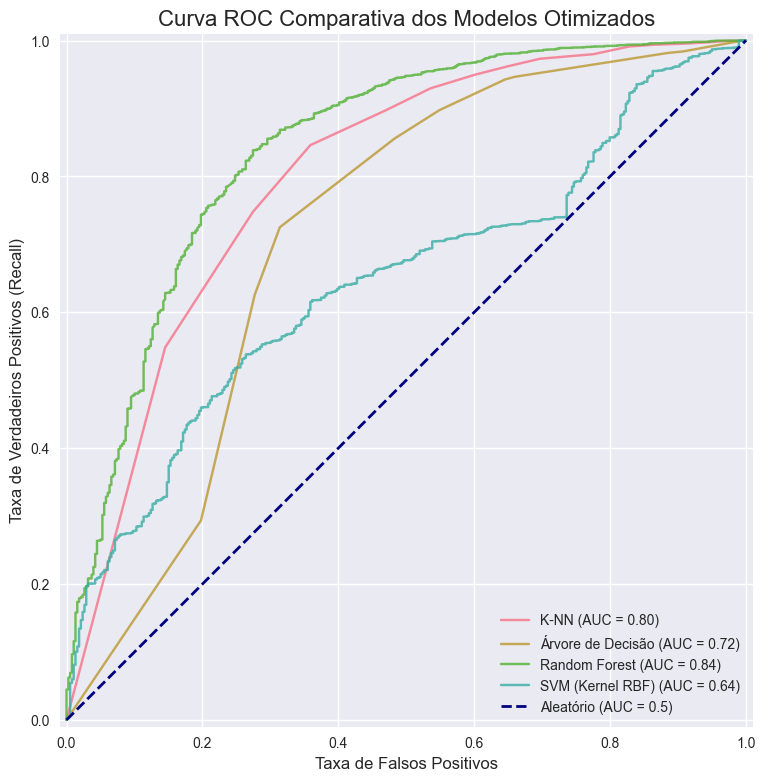

In [ ]:

# Extrai os melhores modelos da busca
best_models = {name: result['best_estimator'] for name, result in search_results.items()}

# Configura a figura
plt.figure(figsize=(12, 9))
ax = plt.gca()

# Itera sobre os melhores modelos para plotar cada curva
for name, model_pipeline in best_models.items():
    RocCurveDisplay.from_estimator(
    model_pipeline, X_test_clean, y_test, name=name, ax=ax, curve_kwargs={'alpha': 0.8}
)

# Adiciona a linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.5)')

# Customiza o gráfico
plt.title('Curva ROC Comparativa dos Modelos Otimizados', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)